# Michigan State University  &ndash; Department of Mathematics
## MTH 451 &ndash; Numerical Analysis I &ndash; Fall 2024 Sec 001
---

**Name:** Lowell Monis

**Instructor:** Dr. Di Liu

**Course Grader:** Jason Curtachio

### Final Project

*Implement the Adams Fourth-Order Predictor-Corrector method to solve*

$$
\begin{cases}
\frac{d}{dt}x_1 = -3x_2\\
\frac{d}{dt}x_2 = \frac{1}{3}x_1^2\\
x_1(0)=0, x_2(0)=1
\end{cases}
$$

*on the interval $0\leq t\leq4$*

---
One proceeds with constructing a function that takes in the given conditions, and provides a numerical solution. A phase diagram is also created.

#### Setup

One can use Algorithm $\S$ 5.4 for the Adams-Bashforth-Moulton Fourth-Order Predictor-Corrector Method from the text [1].

To proceed, one can use the following modules:

1. `numpy`: NumPy's vectorization property can be put to good use to perform evaluations on intervals of data between two values.
2. `matplotlib`: To demonstrate the solution and the phase diagram, one needs to generate plots. This module is imported to that end.
3. `sympy`: This module is being used to define symbols and equations effectively.
4. `scipy`: This module is being used to find the actual solutions of the system for comparison.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy import integrate

#### Introduction


Ordinary Differential Equations (ODEs) describe the relationship between a function and its derivatives. They are a fundamental tool in mathematics, physics, engineering, economics, and many other fields. ODEs model a wide variety of natural phenomena, such as population dynamics, heat conduction, and object motion. Given initial conditions, they allow us to understand how a system evolves or space.

Solving ODEs analytically can be challenging or even impossible in many cases, especially for nonlinear or complex systems. This is where numerical methods come into play. Numerical solutions provide approximate answers to ODEs by discretizing the problem and breaking it into smaller, manageable steps. These methods are essential in real-world applications where exact solutions are impractical. Techniques like Euler’s method, Runge-Kutta method, and multistep methods allow for efficient computation of solutions.

The Fourth-Order Predictor-Corrector (ABM) method is a specific numerical approach used for solving ODEs. This method is a type of Adams-Bashforth-Moulton (ABM) method, combining two powerful techniques: the Adams-Bashforth predictor and the Adams-Moulton corrector. 

The Adams-Bashforth method is a predictor that estimates the solution at the next time step using previous values. The Adams-Moulton method is a corrector that refines this estimate using additional information from future steps. When combined with a fourth-order method Runge-Kutta method, it allows for high accuracy in solving stiff or non-stiff ODEs, making it particularly useful in simulations where precision and efficiency are critical. This method’s strength lies in its ability to achieve both high-order accuracy and adaptive step-size control, ensuring reliable and stable solutions in various applications. This is also a multi-step method.

In summary, ODEs and their numerical solutions are essential for modeling real-world systems, and methods like the ABM fourth-order predictor-corrector are powerful tools for obtaining accurate, efficient solutions when analytical methods fall short.

#### Methodology

The following system of ordinary differential equations is provided with initial conditions, defined in the interval $0\leq t\leq 4$:

$$
\begin{cases}
\frac{d}{dt}x_1 = -3x_2\\
\frac{d}{dt}x_2 = \frac{1}{3}x_1^2\\
x_1(0)=0, x_2(0)=1
\end{cases}
$$

The **Adams Fourth Order Predictor-Corrector Method** is broken down into two parts, as mentioned earlier:

1. The Adams-Bashforth (Predictor) Method (Fourth-Order):
$$y^P_{n+1} = y_n +\frac{h}{24}\left( 55 f_n - 59 f_{n-1} + 37 f_{n-2} - 9 f_{n-3} \right)$$

2. The Adams-Moulton (Corrector) Method:
$$y_{n+1} = y_n + \frac{h}{24}\left( 9 f_{n+1} + 19 f_n - 5 f_{n-1} + f_{n-2} \right)$$

One approaches the problem by creating a function with the following steps:

1. Initialize the method by creating some data points to work with using the Fourth Order Runge-Kutta Method ($\text{RK}_4$).
2. Estimate $y^P$ using the Adam-Bashforth Predictor Method.
3. Use the corrector formula with $f(y^P)$ to refine the solution.

#### Code

One first defines the ODE system using functions.

In [2]:
def f1(t, x1, x2):
    return -3 * x2

def f2(t, x1, x2):
    return (1/3) * (x1**2)

A function is created to compute derivatives. In-built functions are avoided.

In [3]:
def diff(t, x1, x2):
    return f1(t, x1, x2), f2(t, x1, x2)

One then proceeds to define a function for a single-step $\text{RK}_4$.

In [4]:
def step_RK4(t, x1, x2, h, maxval):
    K11, K12 = diff(t, x1, x2)
    K21, K22 = diff(t + h / 2, x1 + h * K11 / 2, x2 + h * K12 / 2)
    K31, K32 = diff(t + h / 2, x1 + h * K21 / 2, x2 + h * K22 / 2)
    K41, K42 = diff(t + h, x1 + h * K31, x2 + h * K32)
    
    x1_new = x1 + h * (K11 + 2 * K21 + 2 * K31 + K41) / 6
    x2_new = x2 + h * (K12 + 2 * K22 + 2 * K32 + K42) / 6
    
    # Prevents overflow
    x1_new = min(x1_new, maxval)
    x2_new = min(x2_new, maxval)
    
    return x1_new, x2_new

One can now proceed to define the function of the Adam-Bashforth-Moulton Fourth-Order Predictor-Corrector Method.

In [5]:
def ABM4(f1, f2, a, b, x1_0, x2_0, N, tol=1e10):
    """
    Uses the Adam-Bashforth-Moulton Fourth-Order Predictor-Corrector Method to solve a system of ordinary differential equations.

    Args:
        f1, f2: function, user-defined function of the system of ODEs that needs to be solved.
        a: int, the lower bound of the interval being used for the problem.
        b: int, the upper bound of the interval being used for the problem.
        x1_0: int, the initial value for the first equation of the problem.
        x2_0: int, the initial value for the second equation of the problem.
        N: int, the total number of data points between a and b.
        tol: numeric-like, the tolerance, or maximum value for this instance of the method.
    Returns:
        t: array-like, list of time steps.
        x1: array-like, numerical solutions of f1.
        x2: array-like, numerical solutions of f2.
    """

    # Computing step-size, h
    h = (b-a)/N
    
    # Creating arrays for the solution
    t = [a]
    x1 = [x1_0]
    x2 = [x2_0]

    # Initializing computation using RK4 for the first four points
    for i in range(3):
        t_new = t[-1] + h
        x1_new, x2_new = step_RK4(t[-1], x1[-1], x2[-1], h, tol)
        t.append(t_new)
        x1.append(x1_new)
        x2.append(x2_new)

    # Creating a loop for the Predictor-Corrector method
    while t[-1] < b:
        t_new = t[-1] + h

        # Adams-Bashforth Predictor
        f1v = [f1(t[-j], x1[-j], x2[-j]) for j in range(4)]
        f2v = [f2(t[-j], x1[-j], x2[-j]) for j in range(4)]
        x1p = x1[-1] + (h/24) * (55*f1v[0]-59*f1v[1]+37*f1v[2]-9*f1v[3])
        x2p = x2[-1] + (h/24) * (55*f2v[0]-59*f2v[1]+37*f2v[2]-9*f2v[3])

        # Adams-Moulton Corrector
        f1c = f1(t_new, x1p, x2p)
        f2c = f2(t_new, x1p, x2p)
        x1c = x1[-1] + (h/24) * (9*f1c+19*f1v[0]-5*f1v[1]+f1v[2])
        x2c = x2[-1] + (h/24) * (9*f2c+19*f2v[0]-5*f2v[1]+f2v[2])

        # Preventing overflow
        x1c = min(x1c, tol)
        x2c = min(x2c, tol)

        # Appending the final values
        t.append(t_new)
        x1.append(x1c)
        x2.append(x2c)

    return np.array(t), np.array(x1), np.array(x2)

Now that the function has been defined, it can be implemented for the given ODE system.

In [6]:
a, b = 0, 4
x1_0, x2_0 = 0, 1
N = 100
t, X1, X2 = ABM4(f1, f2, a, b, x1_0, x2_0, N)

The numerical results can now be visualized.

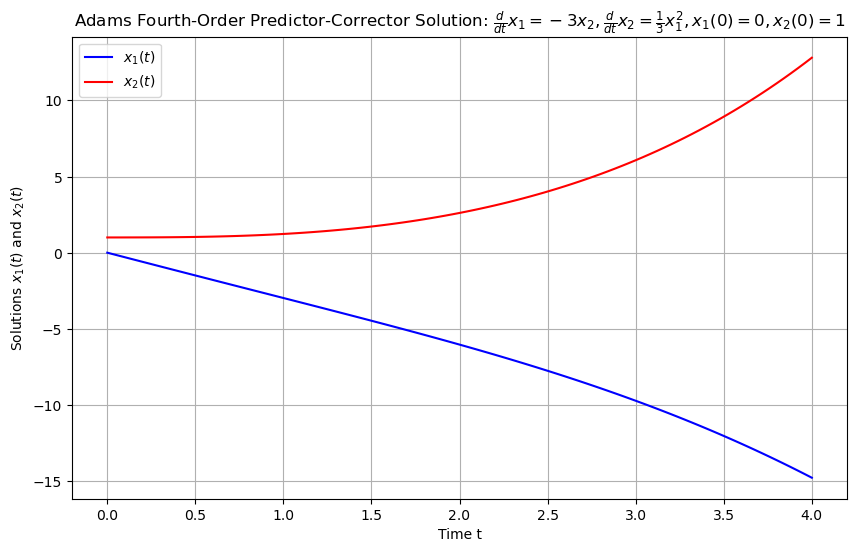

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, X1, label='$x_1(t)$', color='b')
plt.plot(t, X2, label='$x_2(t)$', color='r')
plt.title(r"Adams Fourth-Order Predictor-Corrector Solution: $\frac{d}{dt}x_1 = -3x_2, \frac{d}{dt}x_2 = \frac{1}{3}x_1^2, x_1(0)=0, x_2(0)=1$")
plt.xlabel("Time t")
plt.ylabel(r"Solutions $x_1(t)$ and $x_2(t)$")
plt.legend()
plt.grid()
plt.show()

#### Discussion

To understand the method, one can plot the direction field of the system. First, one defines the functions via `SymPy`.

In [8]:
# Defining symbols for compatibility
x1, x2 = sympy.symbols("x1 x2")

# Defining system of ODEs
f1 = -3 * x2
f2 = (1 / 3) * x1**2

# Creating function via SymPy for numerical evaluation
f1_np = sympy.lambdify((x1, x2), f1, 'numpy')
f2_np = sympy.lambdify((x1, x2), f2, 'numpy')

Now, one can define a function to plot the direction field. The following function takes inspiration from code provided by the instructor. [2]

In [9]:
def plot_direction_field(x1, x2, f1, f2, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    x1_vec = np.linspace(x_lim[0], x_lim[1], 20)
    x2_vec = np.linspace(y_lim[0], y_lim[1], 20)
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    dx = x1_vec[1] - x1_vec[0]
    dy = x2_vec[1] - x2_vec[0]
    for m, xx1 in enumerate(x1_vec):
        for n, xx2 in enumerate(x2_vec):
            Dx = f1_np(xx1, xx2) * dx
            Dy = f2_np(xx1, xx2) * dy
            ax.quiver(xx1, xx2, Dx, Dy, angles='xy', scale_units='xy', scale=5, color='red', alpha=0.5)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title(r"$\frac{dx_1}{dt} = -3x_2, \frac{dx_2}{dt} = \frac{1}{3}x_1^2$")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    return ax

One can then plot the system once again.

In [10]:
def system(t, init):
    x1, x2 = init
    dx1dt = -3 * x2
    dx2dt = (1/3) * x1**2
    return [dx1dt, dx2dt]

The system is now solved using `scipy.integrate.solve_ivp()`. This solution is then utilized to plot the direction field below.

In [11]:
t_span = np.linspace(0, 4, 100)
solution = integrate.solve_ivp(system, [t_span[0], t_span[-1]], [x1_0, x2_0], t_eval=t_span)

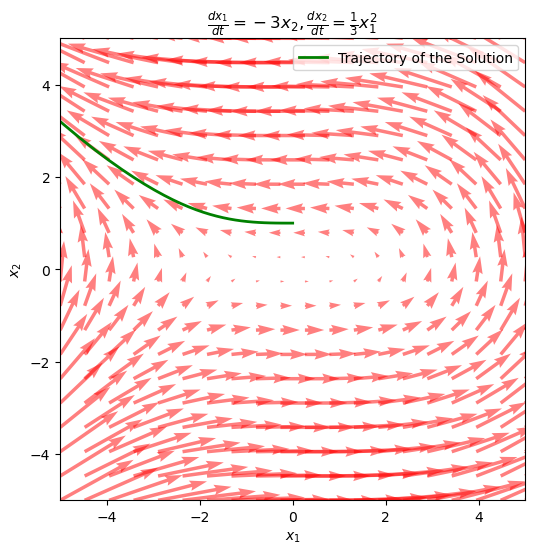

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_direction_field(x1, x2, f1, f2, ax=ax)
ax.plot(solution.y[0], solution.y[1], label='Trajectory of the Solution', color='green', lw=2)
ax.legend()
plt.show()

#### Conclusion

One can conclude that through the Adams-Bansforth-Moulton Fourth-Order Predictor Corrector Method, it has been demonstrated that the solutions of the system of ordinary differential equations **diverge**. This is further corroborated by the direction field that has been plotted, which demonstrates said divergence.

The following are the numerical results of the ODEs through the $\text{ABM}_4$ method.

In [13]:
from tabulate import tabulate
table_data = zip(t, X1, X2)
headers = ["Time (t)", "x_1(t)", "x_2(t)"]
print(tabulate(table_data, headers=headers, floatfmt=".4f", tablefmt="grid"))

+------------+----------+----------+
|   Time (t) |   x_1(t) |   x_2(t) |
+============+==========+==========+
|     0.0000 |   0.0000 |   1.0000 |
+------------+----------+----------+
|     0.0400 |  -0.1200 |   1.0001 |
+------------+----------+----------+
|     0.0800 |  -0.2400 |   1.0005 |
+------------+----------+----------+
|     0.1200 |  -0.3602 |   1.0017 |
+------------+----------+----------+
|     0.1600 |  -0.4801 |   1.0026 |
+------------+----------+----------+
|     0.2000 |  -0.5999 |   1.0038 |
+------------+----------+----------+
|     0.2400 |  -0.7196 |   1.0055 |
+------------+----------+----------+
|     0.2800 |  -0.8393 |   1.0078 |
+------------+----------+----------+
|     0.3200 |  -0.9588 |   1.0107 |
+------------+----------+----------+
|     0.3600 |  -1.0782 |   1.0143 |
+------------+----------+----------+
|     0.4000 |  -1.1976 |   1.0188 |
+------------+----------+----------+
|     0.4400 |  -1.3168 |   1.0241 |
+------------+----------+----------+
|

### Honors Option

*Implement the Fourth-Order Runge-Kutta method with adaptive time steps and solve*

$$
\begin{cases}
\frac{d}{dt}x_1 = -3x_2\\
\frac{d}{dt}x_2 = \frac{1}{3}x_1^2\\
x_1(0)=0, x_2(0)=1
\end{cases}
$$

*on the interval $0\leq t\leq4$*

---
One proceeds with constructing a function that takes in the given conditions, and provides a numerical solution.

#### Setup

One can use Algorithm $\S$ 5.3 for the Runge-Kutta-Fehlberg Method from the text [1].

To proceed, one can use the following modules:

1. `numpy`: NumPy's vectorization property can be put to good use to perform evaluations on intervals of data between two values.
2. `matplotlib`: To demonstrate the solution and the phase diagram, one needs to generate plots. This module is imported to that end.
3. `scipy`: This module is being used to find the actual solutions of the system for comparison.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def f1(t, x1, x2):
    return -3 * x2

def f2(t, x1, x2):
    return (1/3) * (x1**2)

#### Methodology

The Fourth Order Runge-Kutta Method ($\text{RK}_4$) can be defined using the following formula:

$$y_{n+1} = y_n + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4)$$
where:
$$k_1 = f(t_n, y_n)$$
$$k_2 = f \left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_1 \right)$$
$$k_3 = f \left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_2 \right)$$
$$k_4 = f(t_n + h, y_n + hk_3)$$

In this problem, one attempts to include an adaptive time-step to dynamically reduce the step size during numerical integration based on the error calculated at each time step. Thus, if the error calculated exceeds a defined tolerance level, the step size drops to improve accuracy.

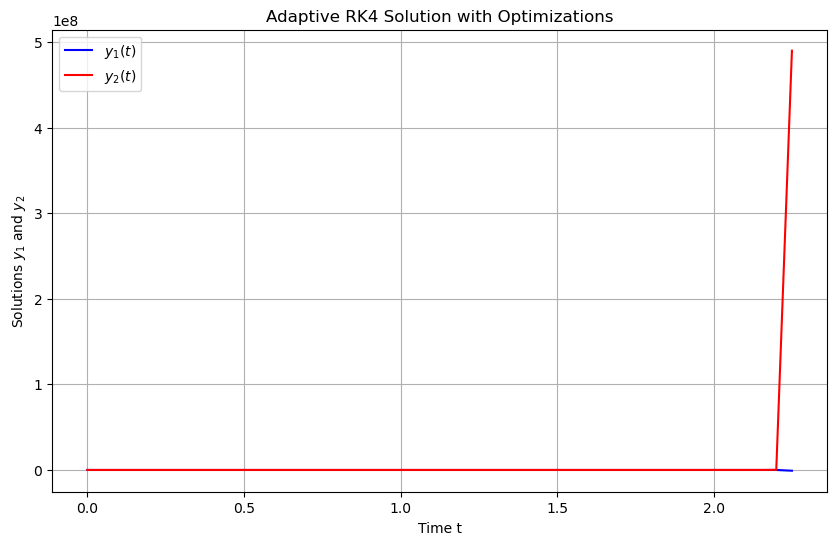

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def RK4_A(t_start, t_end, y1_start, y2_start, h_initial, tolerance=1e-6, h_min=0.05, h_max=0.5, tol=10e10):
    time = [t_start]
    y1 = [y1_start]
    y2 = [y2_start]
    h = h_initial
    
    while time[-1] < t_end:
        y1_full, y2_full = step_RK4(time[-1], y1[-1], y2[-1], h, tol)
        
        if np.abs(y1_full) > tol:
            break
        y1_full = min(y1_full, tol)
        y2_full = min(y2_full, tol)
    
        y1_half, y2_half = step_RK4(time[-1], y1[-1], y2[-1], h / 2, tol)
        y1_half2, y2_half2 = step_RK4(time[-1] + h / 2, y1_half, y2_half, h / 2, tol)
        
        error_y1 = np.abs(y1_half2 - y1_full)
        error_y2 = np.abs(y2_half2 - y2_full)
        
        error = max(error_y1, error_y2)
    
        if error > tolerance:
            if h == h_min:
                time.append(time[-1] + h)
                y1.append(y1_full)
                y2.append(y2_full)
            else:
                h = max(h / 2, h_min)
        else:
            time.append(time[-1] + h)
            y1.append(y1_full)
            y2.append(y2_full)
    
            if error < tolerance / 2:
                h = min(h * 2, h_max)
    
    return np.array(time), np.array(y1), np.array(y2)

t_start, t_end = 0, 4
y1_start, y2_start = 0, 1
h_initial = 0.05

time, y1, y2 = RK4_A(t_start, t_end, y1_start, y2_start, h_initial)

plt.figure(figsize=(10, 6))
plt.plot(time, y1, label='$y_1(t)$', color='b')
plt.plot(time, y2, label='$y_2(t)$', color='r')
plt.title("Adaptive RK4 Solution with Optimizations")
plt.xlabel("Time t")
plt.ylabel("Solutions $y_1$ and $y_2$")
plt.legend()
plt.grid()
plt.show()


#### Conclusion

The following are the numerical solutions.

In [16]:
from tabulate import tabulate
table_data = zip(t, y1, y2)
headers = ["Time (t)", "x_1(t)", "x_2(t)"]
print(tabulate(table_data, headers=headers, floatfmt=".4f", tablefmt="grid"))

+------------+--------------+----------------+
|   Time (t) |       x_1(t) |         x_2(t) |
+============+==============+================+
|     0.0000 |       0.0000 |         1.0000 |
+------------+--------------+----------------+
|     0.0400 |      -0.1500 |         1.0001 |
+------------+--------------+----------------+
|     0.0800 |      -0.4504 |         1.0034 |
+------------+--------------+----------------+
|     0.1200 |      -0.7529 |         1.0157 |
+------------+--------------+----------------+
|     0.1600 |      -1.0613 |         1.0433 |
+------------+--------------+----------------+
|     0.2000 |      -1.2194 |         1.0650 |
+------------+--------------+----------------+
|     0.2400 |      -1.3812 |         1.0932 |
+------------+--------------+----------------+
|     0.2800 |      -1.5477 |         1.1290 |
+------------+--------------+----------------+
|     0.3200 |      -1.7203 |         1.1735 |
+------------+--------------+----------------+
|     0.3600 

### References

[1] R. L. Burden and J. D. Faires, Numerical Analysis, 9th ed. Florence, AL: Cengage Learning, 2010.

[2] D. Liu, "ODE Solver." 2024.